In [1]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score

%matplotlib inline

# Read data

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
all_df = train_df.append(test_df)

all_df['is_test'] = all_df.Survived.isnull()
all_df.index = all_df.Survived


In [3]:
all_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,is_test
Survived,,,,,,,,,,,,,
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,False
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,False
1,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,False
1,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,False
0,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,False


# Target variable

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Target variable is **Survived**.

# Quality metric

Your score is the percentage of passengers you correctly predict. That means - **accuracy**.

# Model

## One variable model
Let's build a very simple model, based on one variable.
That nobody will survived.

In [5]:
def select_features(df):
    non_obj_feats = df.columns[ df.dtypes != 'object' ]
    black_list = ['PassengerId', 'is_test', 'Survived']
    
    return [feat for feat in non_obj_feats if feat not in black_list ]

def get_X_y(df):
    feats = select_features(df)
    
    X = df[feats].values
    y = df.index.values.astype(int)
    
    return X, y

def check_quality(model, X, y, n_folds=5, random_state=0, shuffle=True):
    skf = StratifiedKFold(y, n_folds=n_folds, random_state=random_state, shuffle=shuffle)
    scores = []
    
    for train_index, test_index in skf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        
        scores.append(score)
        
    return np.mean(scores), np.std(scores)

def train_and_verify(df, model):
    X, y = get_X_y( df[ df.is_test == False ] )
    return check_quality(model, X, y)

def iteration_modeling(all_df, model = RandomForestClassifier(), iterations=300):
    res = [train_and_verify(all_df, model)[0] for x in range(iterations)]
    return {'min': np.min(res), 'mean': np.mean(res), 'max': np.max(res) }

def get_importance_features(data, model, limit):
    X,y = get_X_y(data)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort([0], ascending=False) [:limit]
    return feats.rename(columns={0:'feature'})
    
def draw_importance_features(data, model=RandomForestClassifier(), limit=30):
    feats = get_importance_features(data, model, limit)
    feats.plot(kind='bar', figsize=(20, 8))

In [6]:
class SingleVariableModel(BaseEstimator, ClassifierMixin):
    def __init__(self, seed=1):
        np.random.seed(seed)

    def fit(self, X, y):
        return self
        
    def predict(self, X):
        
        
        return [0] * len(X)
    
    def __repr__(self):
        return 'SingleVariableModel'

## Run & evoluate single variable model

In [7]:
train_and_verify(all_df, SingleVariableModel())

(0.61616490890978648, 0.0015536004208290756)

**What do you think about this result?**

## Let's build more advanced model

### Missing values
There're several methods how to manage missing values, let's fill out -1.

In [8]:
all_df.fillna(-1, inplace=True)

In [9]:
iteration_modeling(all_df)

{'max': 0.70819423594760877,
 'mean': 0.68713759526281004,
 'min': 0.66330648378760526}

The result looks better than previous one (**0.616** vs **0.68**).  

## Categorical variables
*or how to manage it*


Let’s try understand better topic related with categorical variables and transformation (usually there’re a lot of categorial variables in real dataset).

### Transforming categorical variables is required?
For some algorithm yes. For example for  linear models, SVMs with the standard kernels and (what the most significant for most cases) XGBboost.
In theory Random Forest (RF) should able works with “string", but for sklearn implementation is required transforming to float (or should be able casting to float).

Here is checking: [check_array](https://github.com/scikit-learn/scikit-learn/blob/0.17.X/sklearn/ensemble/forest.py#L212) and DTYPE is [float32](https://github.com/scikit-learn/scikit-learn/blob/0.17.X/sklearn/tree/_tree.pyx#L50).


### How many options there’re how to mange categorical variables?
At least three:
* keep as is (sting), but it doesn’t work for some algorithms (and this is why most rarely option)
* transform string into unique integer - [label encoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
* transform for each classes into an unique column and use 0/1 (you can treat it like - false/true) - [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)

### Which one is better?
It depends… remember that in machine learning (ML) matter only score and feel comfortable with focusing first on score and only later on interpretation (it’s very pragmatic approach). I believe that there’re cases when you can use all possible options how to represent categorical variables.

But, be aware that hot-encoding sounds more sensible (from semantic point of view) than label encoding.
Let say, there’s transformation - female => 0, male => 1. When you use integer in one column for algorithm it looks at least comparable, e.g. "1 > 0", but for our case "male > female" looks meaningless... or do you have some ideas how to interpret given case :).

### Show me the data, talk is cheap (c)!


### How to interpret the score? 
When you run RF twice you will note a bit different result. Why? Because random_state is None. If you want to see that same result, you should assign some number (this point in the last step could help improve and win, but for initial up to you).

I’ll run 300 times “train_and_verify", so it’ll be generate 300 scores. And this is why like a result will be 3 numbers: min, mean and max (btw, usually mean looks quite stable, even if you run few times).

In [24]:
if 'sex_male' not in all_df:
    one_hot = pd.get_dummies( all_df.Sex, prefix='sex')
    all_df = pd.concat( [all_df, one_hot], axis=1 )
    
    
from sklearn.preprocessing import LabelEncoder
all_df['sex_map'] = LabelEncoder().fit(all_df['Sex']).transform(all_df['Sex'])

### label encoder

In [29]:
def select_features(df):
    non_obj_feats = df.columns[ df.dtypes != 'object' ]
    black_list = ['PassengerId', 'is_test', 'Survived', 'sex_male', 'sex_female']
    
    return [feat for feat in non_obj_feats if feat not in black_list ]

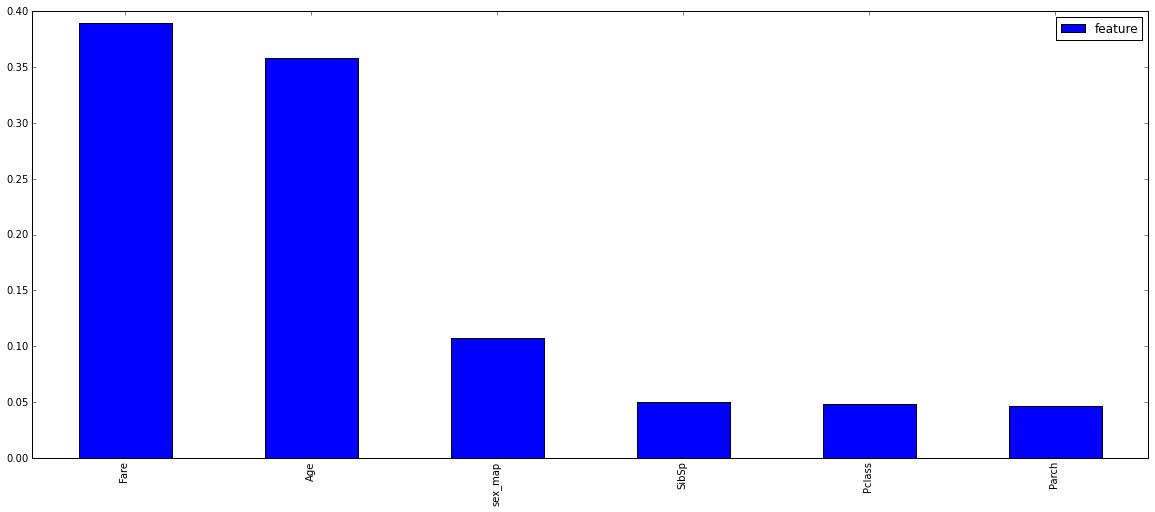

In [30]:
draw_importance_features(all_df)

In [33]:
iteration_modeling(all_df)

{'max': 0.81373203011433137,
 'mean': 0.79736058822882716,
 'min': 0.77780137294058027}

### one-hot encoder

In [47]:
def select_features(df):
    non_obj_feats = df.columns[ df.dtypes != 'object' ]
    black_list = ['PassengerId', 'is_test', 'Survived', 'sex_map']
    
    return [feat for feat in non_obj_feats if feat not in black_list ]

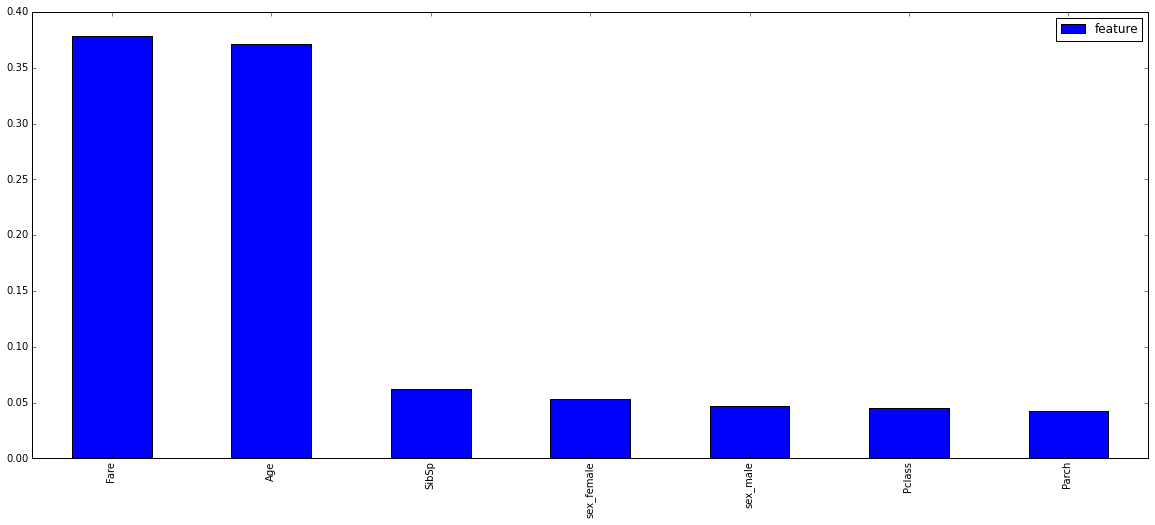

In [48]:
draw_importance_features(all_df)

In [49]:
iteration_modeling(all_df)

{'max': 0.81485562561994929,
 'mean': 0.79749210289051387,
 'min': 0.77777626466112504}

### label encoder & one-hot encoder

In [51]:
def select_features(df):
    non_obj_feats = df.columns[ df.dtypes != 'object' ]
    black_list = ['PassengerId', 'is_test', 'Survived']
    
    return [feat for feat in non_obj_feats if feat not in black_list ]

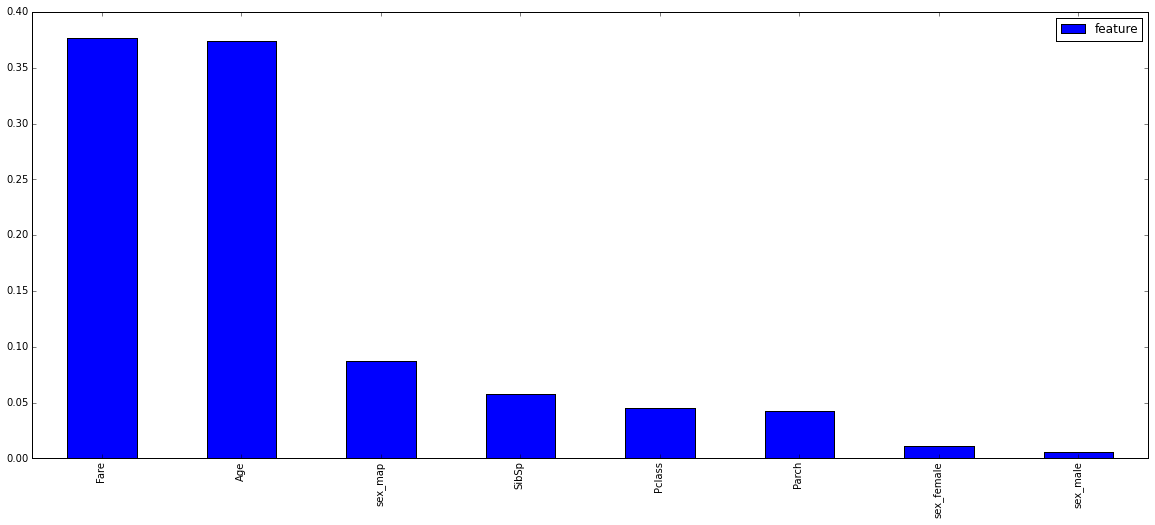

In [54]:
draw_importance_features(all_df)

In [52]:
iteration_modeling(all_df)

{'max': 0.81484934855008562,
 'mean': 0.79715503984284397,
 'min': 0.77663983130640712}

### In summary
* one_hot encoder looks a bit better: **0.79749** (one-hot) compare to **0.79736** (label)
* one_hot & label at the same time provide the worst score - **0.79716**
* this is why using one_hot for this task looks more sensible than other options